In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [3]:
from gensim import models

In [4]:
# Plotting tools
import pyLDAvis

In [5]:
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [6]:
#cleaning and filter the words
import datetime
import sys
import codecs
import re
import urllib, urllib2
import itertools, collections

import nltk  # Natural Language Processing
#nltk.download('punkt')
#nltk.download('all')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords # list of words
from collections import Counter  # optimized way to do this
import string  # list(string.punctuation) - produces a list of punctuations
import copy
from itertools import product, tee, combinations, chain
from nltk.stem import PorterStemmer
from operator import itemgetter # help with dataframes

from scipy.spatial.distance import cosine

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

#from tweepy import Stream

encodingTot = sys.stdout.encoding or 'utf-8'

In [7]:
SOME_FIXED_SEED = 42
# before training/inference: 
np.random.seed(SOME_FIXED_SEED)

## 0. Pre-define functions

let predefine some functions and constant to get ready for later processing

In [8]:
# Regex from Gagan ************************************************************

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

# Regex_str is used to GET text from CSV file

regex_str = [
    
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-signs
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)' # other words
]

# These Regex are used to EXCLUDE items from the text AFTER IMPORTING from csv with regex_str

numbers = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
URL = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
html_tag = r'<[^>]+>'
hash_tag = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
at_sign = r'(?:@[\w_]+)'
dash_quote = r"(?:[a-z][a-z'\-_]+[a-z])"
other_word = r'(?:[\w_]+)'
other_stuff = r'(?:\S)' # anything else - NOT USED
start_pound = r"([#?])(\w+)" # Start with #
start_quest_pound = r"(?:^|\s)([#?])(\w+)" # Start with ? or with #
cont_number = r'(\w*\d\w*)' # Words containing numbers

# My REGEX **************************************************************************

#      Remove '[' and ']' brackets

sq_br_f = r'(?:[[\w_]+)' # removes '['
sq_br_b = r'(?:][\w_]+)' # removes ']'

rem_bracket = r'(' + '|'.join([sq_br_f, sq_br_b]) +')'
rem_bracketC = re.compile(rem_bracket, re.VERBOSE)

# Removes all words of 2 characters or less *****************************************************

short_words = r'\W*\b\w{1,2}\b' # Short words of 3 character or less
short_wordsC = re.compile(short_words, re.VERBOSE | re.IGNORECASE)

# REGEX remove all words with \ and / combinations

slash_back =  r'\s*(?:[\w_]*\\(?:[\w_]*\\)*[\w_]*)'
slash_fwd = r'\s*(?:[\w_]*/(?:[\w_]*/)*[\w_]*)'
slash_all = r'\s*(?:[\w_]*[/\\](?:[\w_]*[/\\])*[\w_]*)'

# REGEX numbers, short words and URL only to EXCLUDE +++++++++++++++++++++++++++++++++++++++++++++++++++

num_url_short = r'(' + '|'.join([numbers, URL, short_words + sq_br_f + sq_br_b]) +')'  # Exclude from tweets
comp_num_url_short = re.compile(num_url_short, re.VERBOSE | re.IGNORECASE)

# Master REGEX to INCLUDE from the original tweets ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

list_regex = r'(' + '|'.join(regex_str) + ')'

master_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE) # TAKE from tweets INITIALLY

In [9]:
char_remove = [']', '[', '(', ')', '{', '}'] # characters to be removed

#the other 3character length words will be removed
words_keep = ['old', 'new', 'age', 'lot', 'bag', 'top', 'cat', 'bat', 'sap', 'jda', 'tea', 'dog', 'lie', 'law', 'lab',\
             'mob', 'map', 'car', 'fat', 'sea', 'saw', 'raw', 'rob', 'win', 'can', 'get', 'fan', 'fun', 'big',\
             'use', 'pea', 'pit','pot', 'pat', 'ear', 'eye', 'kit', 'pot', 'pen', 'bud', 'bet', 'god', 'tax', 'won', 'run',\
              'lid', 'log', 'pr', 'pd', 'cop', 'nyc', 'ny', 'la', 'toy', 'war', 'law', 'lax', 'jfk', 'fed', 'cry', 'ceo',\
              'pay', 'pet', 'fan', 'fun', 'usd', 'rio']

emotion_list = [':)', ';)', '(:', '(;', '}', '{','}']


word_garb = ['here', 'there', 'where', 'when', 'would', 'should', 'could','thats', 'youre', 'thanks', 'hasn',\
             'thank', 'https', 'since', 'wanna', 'gonna', 'aint', 'http', 'unto', 'onto', 'into', 'havent',\
             'dont', 'done', 'cant', 'werent', 'https', 'u', 'isnt', 'go', 'theyre', 'each', 'every', 'shes', 'youve', 'youll',\
            'weve', 'theyve']

extra_word_garb = []

#extra_word_garb = ['today','london','greater']

# Dictionary with Replacement Pairs ******************************************************************************
#repl_dict = {'googleele': 'goog', 'lyin': 'lie', 'googles': 'goog', 'aapl':'apple',\
#             'msft':'microsoft', 'google': 'goog', 'googl':'goog'}

repl_dict = {}

exclude = list(string.punctuation) + emotion_list + word_garb + extra_word_garb

# Convert tuple to a list, then to a string; Remove the characters; Stays as a STRING. Porter Stemmer

stemmer=PorterStemmer()
lmtzr = WordNetLemmatizer()

Prerequisites – Download nltk stopwords and spacy model

We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

##### Run in python console
import nltk; nltk.download('stopwords')

##### Run in terminal or command prompt
python3 -m spacy download en

## 1. Prepare Stopwords

We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [10]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## 2. Load tweets data

first test the methods and then write a loop to auto process all data sets

In [17]:
filename = 'london2017_q2'

In [18]:
directory = 'data/'+ filename + '.csv'
#open tweets 
tw_ori = pd.read_csv(open(directory,'rU'), encoding='utf-8', engine='c', header = 0, 
                     error_bad_lines=False,parse_dates=True)
tw_ori.columns = ['id','text','userid','lat','lon','created_at','location']
print("number of records is.%s" % str(len(tw_ori)))

Skipping line 481572: expected 7 fields, saw 14

Skipping line 527338: expected 7 fields, saw 14



number of records is.751168


In [25]:
geo_dire_wards = 'data/london_ward_citymerge.shp'
london_wards = gpd.read_file(geo_dire_wards)
    
geo_dire_msoa = 'data/london_msoa.shp'
london_msoa = gpd.read_file(geo_dire_msoa)   
    
geo_dire_boundary = 'data/london_boundary.shp'
london_boundary = gpd.read_file(geo_dire_boundary)

NameError: name 'gpd' is not defined

## 3. Preliminary data processing

In [24]:
def convert_toSecond(t):
    return mktime(t.timetuple())

def pandas_toDatetime(t):
    return pd.to_datetime(t, format='%Y-%m-%d %H:%M:%S.%f')


def make_point(row):
    return Point(float(row.lon), float(row.lat))


### Set a range
lat = list([51.25,51.8])                
lon = list([-0.7,0.4])  

def remove_by_boundary(df):
    df = df.loc[((df['lat'] >= lat[0]) & (df['lat'] <= lat[1]))]
    df = df.loc[((df['lon'] >= lon[0]) & (df['lon'] <= lon[1]))]
    return df 

def removeOverFrequentAttribute(df, attr):
    unique_elements, counts_elements = np.unique(df[attr], return_counts=True)
    #calculate the mean and standard deviation of the first column
    mean_count=np.mean(counts_elements)
    std_count=np.std(counts_elements)
    #create a mask to find all elements which are in the interval [mean-std, mean+std]
    #mask=[abs(x-mean_count)<(std_count/2) for x in counts_elements]
    #we only remove the right tail
    mask=[(x-mean_count)<(std_count/2) for x in counts_elements]
    #pictures you want to use:
    accepted = unique_elements[mask]
    accepted = pd.DataFrame(accepted)
    accepted.columns = [attr]
    dataset_verify = pd.merge(df, accepted, on=attr, how='inner')
    #check it again
    unique_elements, counts_elements = np.unique(dataset_verify[attr], return_counts=True)
    plt.hist(counts_elements)
    return dataset_verify

def removeOverFrequentAttributes(df, attr1, attr2):
    df['check'] = df[attr1].astype(str) + '_' + df[attr2].astype(str)
    unique_elements, counts_elements = np.unique(df['check'], return_counts=True)
    #calculate the mean and standard deviation of the first column
    mean_count=np.mean(counts_elements)
    std_count=np.std(counts_elements)
    #create a mask to find all elements which are in the interval [mean-std, mean+std]
    #mask=[abs(x-mean_count)<(std_count/2) for x in counts_elements]
    #we only remove the right tail
    mask=[(x-mean_count)<(std_count/2) for x in counts_elements]
    #pictures you want to use:
    accepted = unique_elements[mask]
    accepted = pd.DataFrame(accepted)
    accepted.columns = ['check']
    dataset_verify = pd.merge(df, accepted, on='check', how='inner')
    #check it again
    unique_elements, counts_elements = np.unique(dataset_verify['check'], return_counts=True)
    plt.hist(counts_elements)
    return dataset_verify

In [21]:
def get_tweet_in_area(tw_ori, boundary, area):
    df_tw = tw_ori
    
    #get the points in the big boundary
    print("clean doc by boundary...")
    t0 = time()
    df_tw = remove_by_boundary(df_tw)
    print("done in %0.3fs." % (time() - t0))
    
    print("original number of tw: %d", len(df_tw))
    df_tw = removeOverFrequentAttribute(df_tw, 'userid')
    print(" number of tw after removing userid: %d", len(df_tw))
    
    df_tw = removeOverFrequentAttributes(df_tw, 'lon', 'lat')
    print(" number of tw after removing coords: %d", len(df_tw))
    
    
    tw = df_tw
    #tw = tw[tw['location'].notnull()]
    #tw = tw[tw['created_at'] <> ' tomato']
    tw['created_at'] =  pd.to_datetime(tw['created_at'])
    
    c = tw.created_at.apply(lambda x: convert_toSecond(x))
    
    tw['time'] = c
    tw['userid'] = tw['userid'].astype(object)
    tw = tw.sort_values(by = 'time', ascending = True)
    points = tw.apply(make_point, axis=1)
    tw_points = gpd.GeoDataFrame(tw, geometry=points)
    tw_points.crs = {'init': 'epsg:4326'}
    
    #remove braodcasting tweets
    tw_in_boundary = gpd.sjoin(tw_points, boundary, op ='within')
    
    #colnames = tw_in_london.columns
    tw_in_boundary = tw_in_boundary[['id','text','userid','lat','lon','created_at', u'location','geometry','time']]
    tw_in_area = gpd.sjoin(tw_in_boundary, area, op ='within')
    return tw_in_area

In [22]:
def filterPick(list, filter):
    return [ ( l, m.group(1) ) for l in list for m in (filter(l),) if m]

search_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE).search

import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

# Convert to list
tweet_list_org = df.text.values.tolist()

tweet_list_org = [str(l).encode('ascii','ignore') for l in tweet_list_org]

### Remove hashtag, URL, and at_sign characters
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [23]:
from time import time

outlist_init = filterPick(tweet_list_org, search_regex) # It is a tuple: initial list from all tweets in area

t0 = time()
outlist_init = [re.sub(URL, "", str(tw_clean)) for tw_clean in outlist_init]
print("URL done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(html_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("HTML_TAG done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(hash_tag, "",str(tw_clean)) for tw_clean in outlist_init]
print("hash_tag done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(slash_all,"", str(tw_clean)) for tw_clean in outlist_init]
print("slash_all done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(cont_number, "",str(tw_clean)) for tw_clean in outlist_init]
print("cont_number done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(numbers, "",str(tw_clean)) for tw_clean in outlist_init]
print("numbers done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(start_pound, "",str(tw_clean)) for tw_clean in outlist_init]

print("pound done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(start_quest_pound, "",str(tw_clean)) for tw_clean in outlist_init]
print("marks done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub(at_sign, "",str(tw_clean)) for tw_clean in outlist_init]
print("at_sign done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub("'", "",str(tw_clean)) for tw_clean in outlist_init]
print("quotation done in %0.3fs." % (time() - t0))
t0 = time()

outlist_init = [re.sub('"', "",str(tw_clean)) for tw_clean in outlist_init]
print("double quotation done in %0.3fs." % (time() - t0))
t0 = time()

# Removes # and @ in words (lookahead)
outlist_init = [re.sub(r'(?:^|\s)[@#].*?(?=[,;:.!?]|\s|$)', r'', tw_clean) for tw_clean in outlist_init] 
print("symbols done in %0.3fs." % (time() - t0))

#data = [" ".join(i) for i in outlist_init]
# Removes shortwords
t0 = time()
outlist_init = [re.sub(short_words, "",str(tw_clean)) for tw_clean in outlist_init]
print("remove shortwords done in %0.3fs." % (time() - t0))

pprint(outlist_init[0])
data = outlist_init

URL done in 4.133s.
HTML_TAG done in 1.424s.
hash_tag done in 3.431s.
slash_all done in 11.998s.
cont_number done in 8.438s.
numbers done in 4.132s.
pound done in 2.655s.
marks done in 3.818s.
at_sign done in 1.546s.
quotation done in 1.897s.
double quotation done in 1.487s.
symbols done in 3.600s.
remove shortwords done in 5.916s.
'(Temp: . Falling. Wind max(last ):.. Pressure: . Falling. Rain Today .. Rainfall last  .. , Temp)'


After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s simple_preprocess is great for this.

## 3. Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [31]:
import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

In [32]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[0])

[u'happy', u'new', u'year', u'the', u'alice', u'bar', u'happy', u'new', u'year', u'beautiful', u'people', u'dirty', u'dicks', u'since', u'its', u'raining', u'must', u'london', u'right', u'london', u'telephone', u'booth', u'the', u'eternals', u'the', u'alice', u'bar', u'happy', u'only', u'photos', u'remembered', u'take', u'cos', u'the', u'night', u'was', u'just', u'too', u'lit', u'fam', u'minus', u'one', u'one', u'new', u'changes', u'roof', u'terrace', u'happy', u'new', u'year', u'sushisamba', u'floor', u'amazing', u'decoration', u'sushisamba', u'floor', u'happy', u'amazing', u'food', u'sushisamba', u'floor', u'happy', u'new', u'year', u'all', u'you', u'people', u'live', u'your', u'life', u'like', u'its', u'porn', u'set', u'love', u'london', u'finishing', u'the', u'incredible', u'year', u'with', u'the', u'most', u'incredible', u'person', u'life', u'the', u'portuguese', u'mafia', u'high', u'the', u'floor', u'wishing', u'everyone', u'happy', u'new', u'year', u'vertigo', u'new', u'year', u

## 4. Creating Bigram and Trigram Models (this is very important)
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘london_bridge’, ‘regent_park’, etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [56]:
#Build the bigram and trigram models

t0 = time()
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
print("building phrases done in %0.3fs." % (time() - t0))

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

building phrases done in 34.496s.
[u'happy', u'new', u'year', u'the', u'alice', u'bar', u'happy', u'new', u'year', u'beautiful', u'people', u'dirty_dicks', u'since', u'its', u'raining', u'must', u'london', u'right', u'london', u'telephone', u'booth', u'the', u'eternals', u'the', u'alice', u'bar', u'happy', u'only', u'photos', u'remembered', u'take', u'cos', u'the', u'night', u'was', u'just', u'too', u'lit', u'fam', u'minus', u'one', u'one', u'new', u'changes', u'roof_terrace', u'happy', u'new', u'year', u'sushisamba_floor', u'amazing', u'decoration', u'sushisamba_floor', u'happy', u'amazing', u'food', u'sushisamba_floor', u'happy', u'new', u'year', u'all', u'you', u'people', u'live', u'your', u'life', u'like', u'its', u'porn', u'set', u'love', u'london', u'finishing', u'the', u'incredible', u'year', u'with', u'the', u'most', u'incredible', u'person', u'life', u'the', u'portuguese', u'mafia', u'high', u'the', u'floor', u'wishing', u'everyone', u'happy', u'new', u'year', u'vertigo', u'ne

In [57]:
data_words[0].count('year')

95

## 5. Remove Stopwords, Make Bigrams and Lemmatize

The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [58]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]



In [59]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_trigrams(data_words_nostops)

In [60]:
from __future__ import unicode_literals
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
import en_core_web_sm
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#nlp = spacy.load('en', disable=['parser', 'ner'])

In [61]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [62]:
# Do lemmatization keeping only noun, adj, vb, adv

t0 = time()
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print("lemmatization done in %0.3fs." % (time() - t0))

print(data_lemmatized[0])

lemmatization done in 99.063s.
[u'happy', u'new', u'year', u'alice', u'bar', u'happy', u'new', u'year', u'beautiful', u'people', u'dirty_dick', u'rain', u'must', u'london', u'right', u'london', u'telephone', u'booth', u'eternal', u'alice', u'bar', u'happy', u'photo', u'remember', u'take', u'night', u'light', u'fam', u'minus', u'new', u'change', u'roof_terrace', u'happy', u'new', u'year', u'sushisamba_floor', u'amazing', u'decoration', u'sushisamba_floor', u'happy', u'amazing', u'food', u'sushisamba_floor', u'happy', u'new', u'year', u'people', u'live', u'life', u'porn', u'set', u'love', u'london', u'finish', u'incredible', u'year', u'incredible', u'person', u'life', u'portuguese', u'mafia', u'high', u'floor', u'wish', u'everyone', u'happy', u'new', u'year', u'new', u'year', u'start', u'style', u'everything', u'delectable', u'compliment', u'chef', u'city', u'social', u'blackfriar', u'london', u'kanaloaclub', u'kanaloa_club', u'start', u'right', u'year', u'wet', u'ass', u'repost', u'danc

In [63]:
data_lemmatized_out = [" ".join(i) for i in data_lemmatized]
data_lemmatized_out = pd.DataFrame(data_lemmatized_out)
to_filename = 'output/cleaned_'+ filename
to_filename
data_lemmatized_out.to_csv(to_filename, encoding='utf-8' )

## 6. Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [67]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 3), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 7), (15, 9), (16, 4), (17, 1), (18, 5), (19, 1), (20, 1), (21, 1), (22, 3), (23, 3), (24, 3), (25, 3), (26, 1), (27, 1), (28, 19), (29, 2), (30, 2), (31, 7), (32, 1), (33, 1), (34, 3), (35, 1), (36, 12), (37, 1), (38, 1), (39, 3), (40, 14), (41, 6), (42, 22), (43, 1), (44, 1), (45, 1), (46, 1), (47, 7), (48, 1), (49, 3), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 20), (58, 1), (59, 2), (60, 4), (61, 1), (62, 3), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 5), (71, 1), (72, 19), (73, 1), (74, 3), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 2), (81, 1), (82, 5), (83, 27), (84, 2), (85, 7), (86, 1), (87, 1), (88, 3), (89, 4), (90, 1), (91, 5), (92, 17), (93, 3), (94, 8), (95, 1), (96, 6), (97, 28), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 2), (104, 1), (105, 7), (106, 3), (107, 4), (108, 2), (109, 5),

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [68]:
id2word[0]

u'daunt_book'

In [69]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'daunt_book', 2),
  (u'foul', 1),
  (u'four', 1),
  (u'betch', 1),
  (u'francesco', 2),
  (u'woody', 1),
  (u'marching', 1),
  (u'otro', 2),
  (u'increase', 3),
  (u'otra', 1),
  (u'igual', 1),
  (u'tony_blair', 1),
  (u'hermano', 1),
  (u'shaving', 1),
  (u'cipfa', 7),
  (u'barbican_concert_hall', 9),
  (u'pigment', 4),
  (u'positive_vib', 1),
  (u'yellow', 5),
  (u'sweetbread', 1),
  (u'bringing', 1),
  (u'lumia', 1),
  (u'prize', 3),
  (u'increble', 3),
  (u'wooden', 3),
  (u'showcas', 3),
  (u'clientele', 1),
  (u'voyeur', 1),
  (u'wednesday', 19),
  (u'ooop', 2),
  (u'oooo', 2),
  (u'solid', 7),
  (u'oxford_circus', 1),
  (u'orientate', 1),
  (u'charter', 3),
  (u'glassy', 1),
  (u'tired', 12),
  (u'lincolnalumniuk', 1),
  (u'glasss', 1),
  (u'ornate', 3),
  (u'bacon', 14),
  (u'elegant', 6),
  (u'second', 22),
  (u'francesca', 1),
  (u'mlm', 1),
  (u'targa', 1),
  (u'hilariously', 1),
  (u'brexit', 7),
  (u'vone_official', 1),
  (u'katsu_curry', 3),
  (u'cooking', 1),
  (u'bu

## 7. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [71]:
# Build LDA model
t0 = time()

lda_model_10_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=10,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
print("Topic model building done in %0.3fs." % (time() - t0))

Topic model building done in 181.081s.


## 8. View the topics in LDA model

The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [73]:
# Print the Keyword in the 10 topics
pprint(lda_model_10_10.print_topics())
doc_lda = lda_model_10_10[corpus]

[(0,
  u'0.091*"soho" + 0.008*"bond_street" + 0.005*"mayfair" + 0.005*"roma_soho" + 0.004*"bbc" + 0.004*"bob_bob_ricard" + 0.004*"wardour" + 0.004*"cirque_soir" + 0.003*"hamleys_regent_street" + 0.003*"temper"'),
 (1,
  u'0.059*"london" + 0.022*"great" + 0.015*"marylebone" + 0.009*"waterloo" + 0.009*"lambeth" + 0.006*"south_bank" + 0.004*"ivy" + 0.004*"theatre" + 0.004*"trafalgar_square" + 0.003*"clapham"'),
 (2,
  u'0.128*"london" + 0.047*"great" + 0.013*"greenwich" + 0.009*"paddington" + 0.007*"day" + 0.006*"westminster" + 0.006*"hotel" + 0.005*"view" + 0.005*"canary_wharf" + 0.005*"city"'),
 (3,
  u'0.015*"chelsea" + 0.007*"park" + 0.005*"walthamstow" + 0.004*"arsenal" + 0.004*"leyton" + 0.004*"wanstead" + 0.004*"hair" + 0.003*"highbury" + 0.003*"repostby" + 0.003*"amp"'),
 (4,
  u'0.022*"wimbledon" + 0.021*"stratford" + 0.018*"richmond" + 0.017*"arena" + 0.013*"stadium" + 0.011*"toot" + 0.009*"white_hart_lane" + 0.008*"tottenham" + 0.007*"langham" + 0.007*"tooting_bec"'),
 (5,
  u'

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

## 9. Compute Model Perplexity and Coherence Score

Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [75]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_10_10.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_10_10, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(u'\nPerplexity: ', -8.35663913213234)
(u'\nCoherence Score: ', 0.6187559974753593)


## 10. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [79]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_10_10, corpus, id2word)
vis

WindowsError: [Error 32] The process cannot access the file because it is being used by another process: 'c:\\users\\k1517671\\appdata\\local\\temp\\joblib_memmapping_folder_20912_4872728133\\20912-1448048176-8da2910e56ad466f8cc680012f119265.pkl'

In [78]:
# Create Document - Topic Matrix
data_vectorized = tf_vectorizer.fit_transform(data_lemmatized)
lda_output = lda_model_10_10.transform(data_vectorized)

# index names
docnames = ["Doc" + str(i) for i in range(len(data_lemmatized))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

So how to infer pyLDAvis’s output?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic.

We have successfully built a good looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Upnext, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.

## 11. Building LDA Mallet Model

So far you have seen Gensim’s inbuilt version of the LDA algorithm. Mallet’s version, however, often gives a better quality of topics.

Gensim provides a wrapper to implement Mallet’s LDA from within Gensim itself. You only need to download the zipfile, unzip it and provide the path to mallet in the unzipped directory to gensim.models.wrappers.LdaMallet. See how I have done this below.

https://anoopacademia.wordpress.com/2015/01/18/install-mallet-on-windows-operating-system/

In [80]:
#import tempfile
#tempfile.tempdir='F:/'

import os 
os.environ.update({'MALLET_HOME':r'F:/workspace/python/mallet-2.0.8/'})


In [81]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'F:/workspace/python/mallet-2.0.8/bin/mallet' # update this path

In [82]:
# Build LDA model
t0 = time()
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)
print("Topic model building using mallet done in %0.3fs." % (time() - t0))

Topic model building using mallet done in 156.640s.


In [83]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [(u'park', 0.016245907),
   (u'today', 0.012700358),
   (u'amp', 0.011761603),
   (u'love', 0.011738327),
   (u'day', 0.011272829),
   (u'make', 0.008410011),
   (u'work', 0.0076884883),
   (u'morning', 0.0070988564),
   (u'happy', 0.0066023245),
   (u'hair', 0.0065557747)]),
 (1,
  [(u'day', 0.014842554),
   (u'greenwich', 0.012704862),
   (u'great', 0.012113586),
   (u'today', 0.011264574),
   (u'good', 0.008490123),
   (u'time', 0.008323353),
   (u'park', 0.008262709),
   (u'year', 0.0067162933),
   (u'amp', 0.00650404),
   (u'love', 0.0061705)]),
 (2,
  [(u'london', 0.23356484),
   (u'great', 0.10715316),
   (u'amp', 0.011561289),
   (u'good', 0.0065843705),
   (u'paddington', 0.0063988953),
   (u'day', 0.0063370704),
   (u'time', 0.0060897702),
   (u'hotel', 0.0057497323),
   (u'knightsbridge', 0.005378782),
   (u'marylebone', 0.0049666143)]),
 (3,
  [(u'day', 0.020562941),
   (u'today', 0.01777532),
   (u'morning', 0.013565673),
   (u'amp', 0.011974358),
   (u'good', 0.009

## 12. How to find the optimal number of topics for LDA?

My approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

The compute_coherence_values() (see below) trains multiple LDA models and provides the models and their corresponding coherence scores.

In [85]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [87]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=10, step=1)

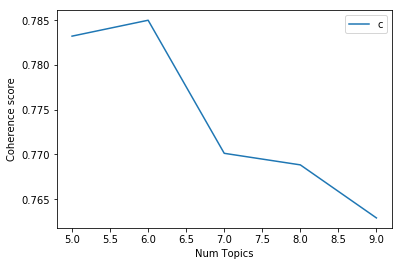

In [138]:
# Show graph
limit=10; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [89]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

(u'Num Topics =', 5, u' has Coherence Value of', 0.7832)
(u'Num Topics =', 6, u' has Coherence Value of', 0.785)
(u'Num Topics =', 7, u' has Coherence Value of', 0.7701)
(u'Num Topics =', 8, u' has Coherence Value of', 0.7688)
(u'Num Topics =', 9, u' has Coherence Value of', 0.7629)


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 20 topics itself.

In [123]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  u'0.019*"amp" + 0.011*"day" + 0.008*"today" + 0.007*"good" + 0.007*"night" + 0.007*"love" + 0.006*"make" + 0.006*"happy" + 0.005*"drink" + 0.005*"lunch"'),
 (1,
  u'0.016*"park" + 0.015*"day" + 0.014*"today" + 0.011*"morning" + 0.008*"time" + 0.008*"love" + 0.008*"good" + 0.007*"work" + 0.006*"session" + 0.006*"amp"'),
 (2,
  u'0.194*"london" + 0.085*"great" + 0.011*"amp" + 0.007*"day" + 0.007*"night" + 0.007*"good" + 0.006*"time" + 0.005*"hotel" + 0.005*"covent_garden" + 0.005*"love"'),
 (3,
  u'0.108*"london" + 0.040*"great" + 0.010*"city" + 0.010*"soho" + 0.009*"day" + 0.009*"night" + 0.009*"good" + 0.008*"amp" + 0.007*"love" + 0.007*"time"'),
 (4,
  u'0.013*"day" + 0.010*"today" + 0.008*"good" + 0.007*"year" + 0.007*"morning" + 0.006*"happy" + 0.006*"great" + 0.006*"time" + 0.006*"work" + 0.005*"posted_photo"'),
 (5,
  u'0.102*"london" + 0.045*"great" + 0.009*"day" + 0.008*"time" + 0.008*"greenwich" + 0.007*"good" + 0.007*"camden" + 0.005*"love" + 0.005*"back" + 0.005*"today

## 18. Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [124]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):  #=lda_model
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.6066,"london, great, city, soho, day, night, good, a...",(Happy New Year !!! The Alice Bar HAPPY NEW Y...
1,1,0.0,0.1616,"amp, day, today, good, night, love, make, happ...",its snowing?? Way more fun than anticipated...
2,2,1.0,0.2942,"park, day, today, morning, time, love, good, w...",(***JANUARY PERSONAL FITNESS DEVELOPMENT WE...
3,3,4.0,0.4484,"day, today, good, year, morning, happy, great,...",(Sons lesson Alfie Eastminster Daughter...
4,4,4.0,0.1987,"day, today, good, year, morning, happy, great,...",(Soundchecking the round for London - Expecta...
5,5,1.0,0.2506,"park, day, today, morning, time, love, good, w...",( would expect nothing less from bonviveur lik...
6,6,0.0,0.2551,"amp, day, today, good, night, love, make, happ...",(Cushion Posy - January child born with disabi...
7,7,4.0,0.5481,"day, today, good, year, morning, happy, great,...",(Despidiendo mejor manera New Year New Y...
8,8,1.0,0.2823,"park, day, today, morning, time, love, good, w...",(Happy new year all beautiful people wish you ...
9,9,4.0,0.2571,"day, today, good, year, morning, happy, great,...",(Watching loving Geografisk det ikke langt m...


(array([606.,  20.,  15., 159., 183.]),
 array([0. , 1.2, 2.4, 3.6, 4.8, 6. ]),
 <a list of 5 Patch objects>)

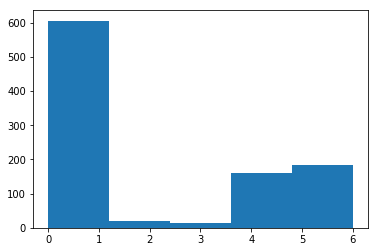

In [126]:
plt.hist(df_dominant_topic['Dominant_Topic'],5)

In [127]:
import pysal as ps
import random
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

from pysal.contrib.viz import mapping as maps


#wknn5 = ps.weights.KNN.from_shapefile('data/london_msoa.shp', k=10)

In [141]:
values = np.array(df_dominant_topic['Dominant_Topic'])


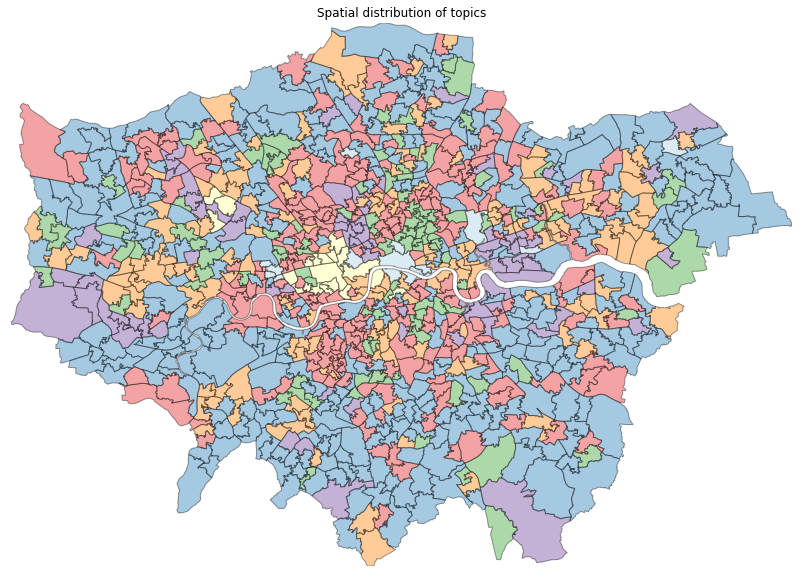

In [137]:
shp_link = 'data/london_msoa.shp'
shp = ps.open(shp_link)

#types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
types = 'unique_values'
maps.plot_choropleth(shp_link, values, types, title='Spatial distribution of topics', figsize=(14, 10))

## 19. Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. Whew!!

In [92]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7916,"park, today, amp, love, day, make, work, morni...",( Thats pretty awful. Such shame there are man...
1,1.0,0.6804,"day, greenwich, great, today, good, time, park...",(Active year These two terrors cleotyso...
2,2.0,0.7038,"london, great, amp, good, paddington, day, tim...",( Source: Tower Bridge twilight James. Petts ...
3,3.0,0.6564,"day, today, morning, amp, good, love, time, se...",(Another Year Another Opportunity Chec...
4,4.0,0.7265,"amp, day, night, good, today, drink, tonight, ...",(This awesome! Cheers Good weekend starts wi...


The tabular output above actually has 20 rows, one each for a topic. It has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.



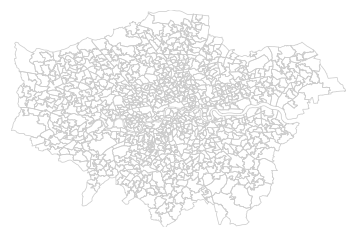

In [139]:
fig = plt.figure()

base = maps.map_poly_shp(shp)
base.set_facecolor('none')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')

ax = maps.setup_ax([base], [shp.bbox, shp.bbox, shp.bbox])
fig.add_axes(ax)
plt.show()

## 20. Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [140]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

TypeError: cannot convert the series to <type 'float'>

## 21. Conclusion

We started with understanding what topic modeling can do. We built a basic topic model using Gensim’s LDA and visualize the topics using pyLDAvis. Then we built mallet’s LDA implementation. You saw how to find the optimal number of topics using coherence scores and how you can come to a logical understanding of how to choose the optimal model.

Finally we saw how to aggregate and present the results to generate insights that may be in a more actionable.

Hope you enjoyed reading this. I would appreciate if you leave your thoughts in the comments section below.